<a href="https://colab.research.google.com/github/tuenguyen004/Exosuit_ML/blob/main/draft_selfmade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SELF-MADE PRE-PROCESSING MODEL 
* for multi-variable, we might have to run a similar training procedure below but with a different hyper-parameter tuning for each - will talk with Aryan if there's a way to train a "tensor" object & its advantages - otherwise, this is doing the same

* large picture, we would calculate all the weights after training each datasets (x,y,z,andles,blah,blah) and load that into a server to call model.predict

* this takes an input array of the history data we want to forecast forward, and will return an array as well

* after getting all the arrays for one timestep - organize them and run them through the POstureID Algorithm to determine which timestep in future is there a potential bad posture 

* we can determine how long that predicted bad postures can last before we actually report that prediction signal to users (through haptics)

things needed from Tom:
* how many datapoints we need as history, how much as forecast data
* how much to sample down from 100hz data collect
* testing methods to new data

Soon, we can move our model into IMU datasets to test

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
mpl.rcParams['figure.figsize'] = 18, 10
mpl.rcParams['lines.linewidth']= 4
mpl.rcParams['lines.markersize'] = 20

In [ ]:
print(tf.__version__)

2.3.0


In [ ]:
#@title import data from Google .csv files into Dataframe
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)
#df.size = 981274


df = pd.read_csv(csv_path)
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [ ]:
#@title Feature Selection (temperature data)
feature = list(df.columns.values)
selected = feature[1]

temp = df[selected]
df_temp = pd.DataFrame(data=temp[0:10000])
#df_temp[:15]

In [ ]:
#@title Split 70-30
split_data = int(len(df_temp) * 0.8)

train_df = df_temp.iloc[0:split_data]
test_df = df_temp.iloc[split_data:]


#BUILDING THE FORECAST MODEL (currently SingleShot Recurrent Neural Network) 

In [ ]:
in_steps = 22
out_steps = 8

def create_dataset(X, y, past=1, future=1):
    Xs, ys = [], []
    for i in range(len(X) - past):
      input_width = i + past
      label_width = input_width + future

      v = X.iloc[i:input_width].values
      Xs.append(v) 

      w = y.iloc[input_width:label_width].values
      test = np.zeros(out_steps)
      if(len(w) < out_steps):
        for i in range(out_steps):
          if i < len(w):
            test[i] = w[i]
          else:
            test[i] = w[-1]
        w = test
      ys.append(w)


    return np.array(Xs), np.array(ys)

In [ ]:
train_size = int(len(df_temp) * 0.7)
test_size = len(df_temp) - train_size 

print(train_size)
print(test_size)

train, test = df_temp.iloc[0:train_size], df_temp.iloc[train_size:len(df_temp)]

# reshape to [samples, in_steps, n_features]
X_train, y_train = create_dataset(train, train[selected], in_steps, out_steps)
X_test, y_test = create_dataset(test, test[selected], in_steps, out_steps)
print(X_train.shape, X_train.shape)
print(y_train.shape)

test = tf.stack(X-train, X_)

7000
3000
(6978, 22, 1) (6978, 22, 1)
(6978, 8)


In [ ]:
X_train[0]

array([[-8.02],
       [-8.41],
       [-8.51],
       [-8.31],
       [-8.27],
       [-8.05],
       [-7.62],
       [-7.62],
       [-7.91],
       [-8.43],
       [-8.76],
       [-8.88],
       [-8.85],
       [-8.83],
       [-8.66],
       [-8.66],
       [-8.7 ],
       [-8.81],
       [-8.84],
       [-8.94],
       [-8.94],
       [-8.86]])

In [ ]:
y_train[0]

array([-8.99, -9.05, -9.23, -9.49, -9.5 , -9.35, -9.47, -9.63])

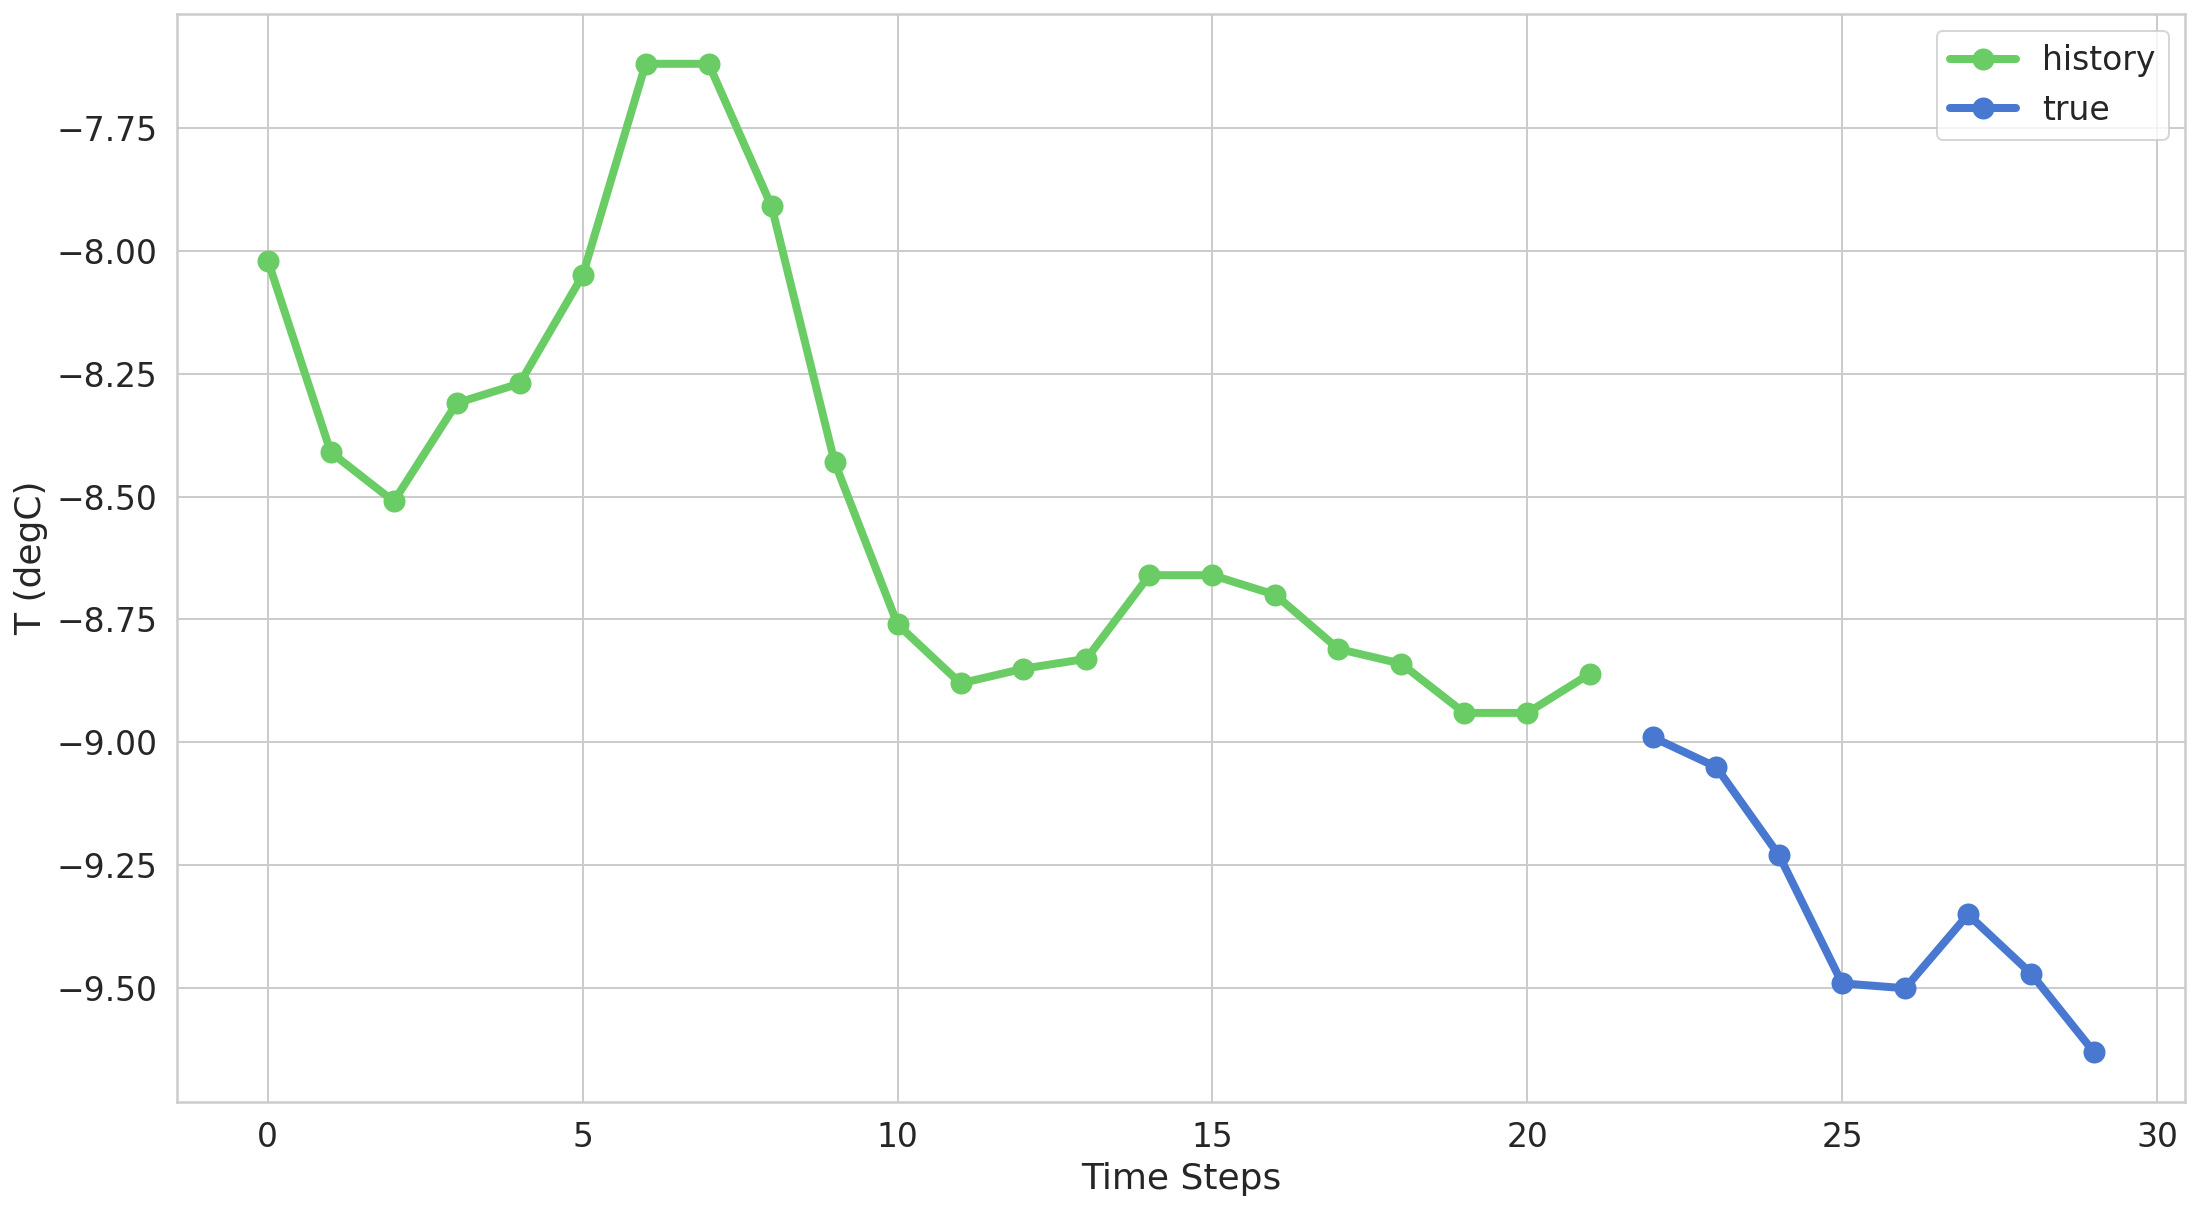

In [ ]:
plt.plot(np.arange(0, len(X_train[0])), X_train[0], 'g', marker='.', label="history")
plt.plot(np.arange(len(X_train[0]), len(X_train[0]) + len(y_train[0])), y_train[0], 'b', marker='.', label="true")
plt.ylabel(selected)
plt.xlabel('Time Steps')
plt.legend()
plt.show()

In [ ]:
model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),

    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(out_steps, kernel_initializer=tf.initializers.zeros),

])

In [ ]:
MAX_EPOCHS = 100


model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam())

X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)

history = model.fit(X_train, y_train, 
                    epochs=MAX_EPOCHS,
                    batch_size=16,
                    validation_split=0.2,
                    verbose=1, shuffle=False)


Epoch 1/600
349/349 [==============================] - 7s 12ms/step - loss: 46.2618 - val_loss: 1.9951
Epoch 2/600
349/349 [==============================] - 3s 10ms/step - loss: 22.2661 - val_loss: 0.8181
Epoch 3/600
349/349 [==============================] - 4s 11ms/step - loss: 11.5524 - val_loss: 0.5835
Epoch 4/600
349/349 [==============================] - 4s 11ms/step - loss: 6.8764 - val_loss: 0.4780
Epoch 5/600
349/349 [==============================] - 4s 11ms/step - loss: 4.5328 - val_loss: 0.4110
Epoch 6/600
349/349 [==============================] - 4s 11ms/step - loss: 3.1907 - val_loss: 0.3733
Epoch 7/600
349/349 [==============================] - 4s 10ms/step - loss: 2.4072 - val_loss: 0.3541
Epoch 8/600
349/349 [==============================] - 4s 10ms/step - loss: 1.8667 - val_loss: 0.3428
Epoch 9/600
349/349 [==============================] - 4s 11ms/step - loss: 1.5349 - val_loss: 0.3372
Epoch 10/600
349/349 [==============================] - 4s 10ms/step - loss: 1.

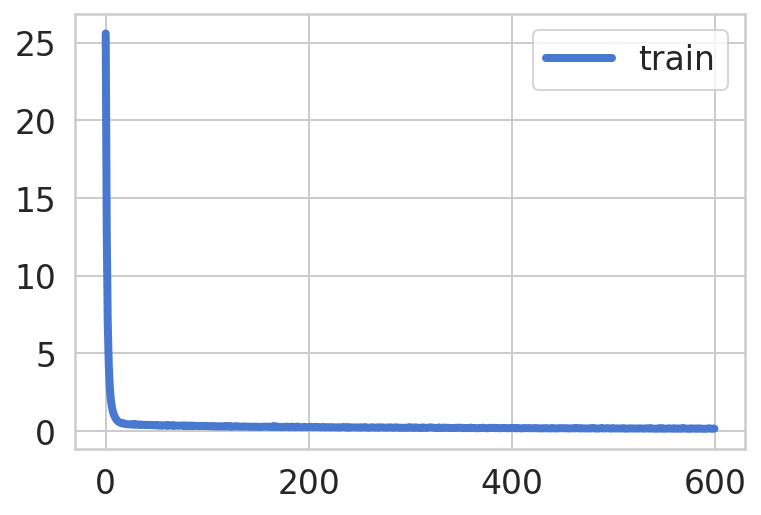

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.legend();

In [ ]:
y_pred = model.predict(X_test)

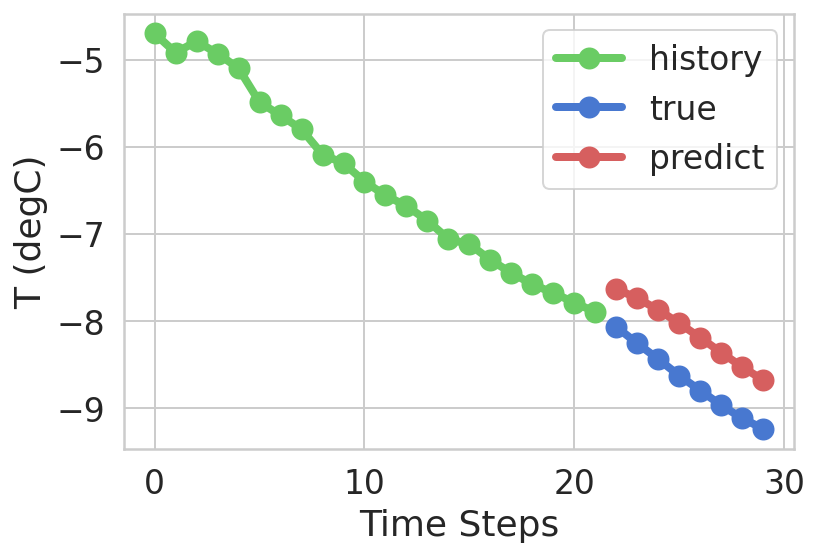

In [ ]:
index = 34

plt.plot(np.arange(0, len(X_test[index])), X_test[index], 'g', marker='.', label="history")
plt.plot(np.arange(len(X_test[index]), len(X_test[index]) + len(y_test[index])), y_test[index], 'b', marker='.', label="true")
plt.plot(np.arange(len(X_test[index]), len(X_test[index]) + len(y_test[index])), y_pred[index], 'r', marker='.', label="predict")
plt.ylabel(selected)
plt.xlabel('Time Steps')
plt.legend()
plt.show();